## Customer Segmentation and lifetime value prediciton

## 1. Exploratory Data Analysis

In [1]:
# Import libraries
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Model
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings(action='ignore')

### Plotting functions for analysis

In [2]:
# Plotting function for analysis

def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

def count_plot(feature, df, colors='#3bc57fff', hue=False, ax=None, title=''):
    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)
    
    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
#        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
#                ha='center', va='bottom') # set the alignment of the text
        ax.annotate(y, (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Greens_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()
    
    
def categorical_plot(cols_cat, axs, df):
    
    idx_row = 0
    for col in cols_cat:
        # Returning column index
        idx_col = cols_cat.index(col)

        # Verifying brake line in figure (second row)
        if idx_col >= 3:
            idx_col -= 3
            idx_row = 1

        # Plot params
        names = df[col].value_counts().index
        heights = df[col].value_counts().values

        # Bar chart
        axs[idx_row, idx_col].bar(names, heights, color='navy')
        if (idx_row, idx_col) == (0, 2):
            y_pos = np.arange(len(names))
            axs[idx_row, idx_col].tick_params(axis='x', labelrotation=30)
        if (idx_row, idx_col) == (1, 1):
            y_pos = np.arange(len(names))
            axs[idx_row, idx_col].tick_params(axis='x', labelrotation=90)

        total = df[col].value_counts().sum()
        axs[idx_row, idx_col].patch.set_facecolor('#FFFFFF')
        format_spines(axs[idx_row, idx_col], right_border=False)
        for p in axs[idx_row, idx_col].patches:
            w, h = p.get_width(), p.get_height()
            x, y = p.get_xy()
            axs[idx_row, idx_col].annotate('{:.1%}'.format(h/1000), (p.get_x()+.29*w,
                                            p.get_y()+h+20), color='k')

        # Plot configuration
        axs[idx_row, idx_col].set_title(col, size=12)
        axs[idx_row, idx_col].set_ylim(0, heights.max()+120)

In [3]:
df = pd.read_csv('./data/Online_Retail.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Missing value counts and corresponding % against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Counts', 'Percentage'])

,Counts,Percentage
CustomerID,135080,24.926694
Description,1454,0.268311
Country,0,0.000000
UnitPrice,0,0.000000
InvoiceDate,0,0.000000
Quantity,0,0.000000
StockCode,0,0.000000
InvoiceNo,0,0.000000


In [6]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
# Converting date columns to datetime
date_columns = ['InvoiceDate']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])
    
# Filter UK data
df = df.query("Country=='United Kingdom'").reset_index(drop=True)

# Creating user dataframe to keep Customer Id and new segmentation scores
df_user = pd.DataFrame(df['CustomerID'].unique())
df_user.columns = ['CustomerID']

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
# Create YearMonth Column
df['YearMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12


In [10]:
df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [11]:
# Create df for plotting customer count
df_cust_count = df.groupby('YearMonth').CustomerID.count().reset_index()
df_cust_count

,YearMonth,CustomerID
0,2010-12,24536
1,2011-01,18738
2,2011-02,18110
3,2011-03,24587
4,2011-04,21358
5,2011-05,25738
6,2011-06,24296
7,2011-07,24170
8,2011-08,23623
9,2011-09,36333


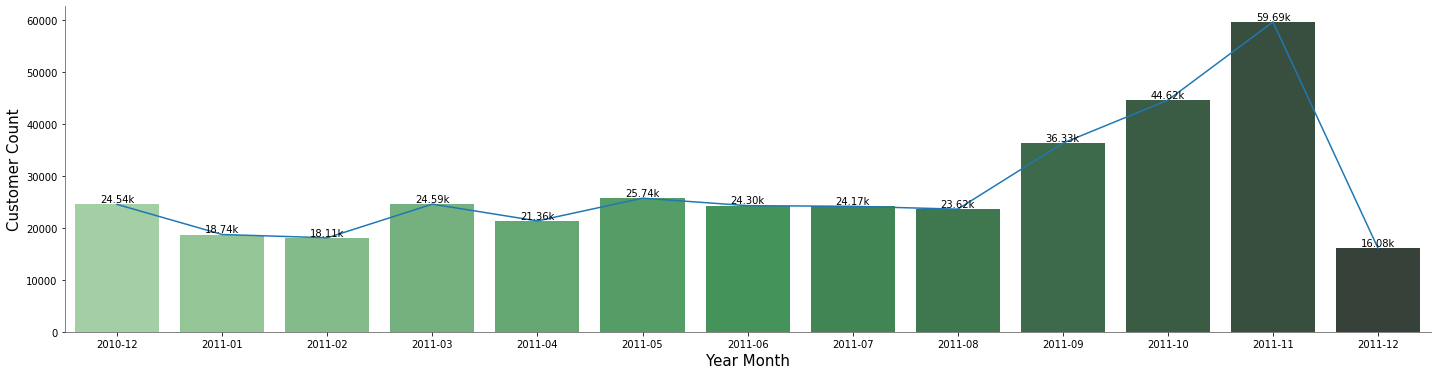

In [12]:
# Plotting customer count
fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.lineplot(x='YearMonth', y='CustomerID', data=df_cust_count)
bar_plot(x='YearMonth', y='CustomerID', df=df_cust_count, value=True)
format_spines(ax, right_border=False)
ax.set_title('')
#fig.suptitle('Number of Customers from 2010-2011', fontweight = 600, size=20)
ax.set_xlabel('Year Month', fontsize = 15)
ax.set_ylabel('Customer Count', fontsize = 15)
plt.subplots_adjust(wspace=0.3, hspace=3, top=.85)

# Savinf fig
#fig1 = plt.gcf()
#plt.show()
#plt.draw()
#fig1.savefig('count_cust.png')


## 2. Customer Segmentation: RFM Analysis

For customer segmentation, it will be used 3 important metrics for marketing analysis and customer lifetime value models.

Recency: When was the customer's last order?

Frequency: How often do they buy?
    
Monetary: What amount do they spend?


#### Segments: 

Low-Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue. 

Mid-Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue. 

High-Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

### Recency

Calculate the number of days between present date and date of last purchase each customer. 

After having the number of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [13]:
# Get the max purchase date for each customer 
df_max_purchase = df.groupby('CustomerID').InvoiceDate.max().reset_index()
df_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']

# The max purchase date is the observation point
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

# Merge with df_user
df_user = pd.merge(df_user, df_max_purchase[['CustomerID','Recency']], on='CustomerID')

df_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


### K-means clustering & Hyperparameters

Apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. 

To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia.

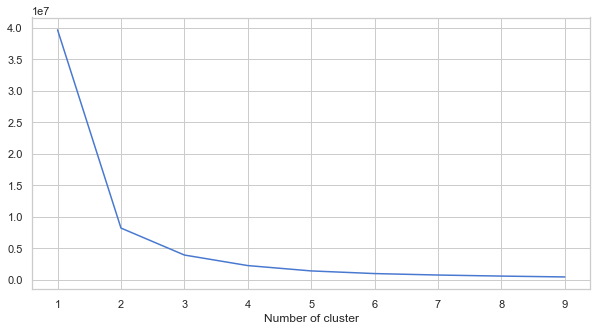

In [14]:
# Choosing optimal hyperparameters
sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_

sns.set(palette='muted', color_codes=True, style='whitegrid')
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [15]:
# Building 4 clusters for recency 
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

In [16]:
# Displaying the details of each cluster
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.0,47.0
1,478.0,304.393305,41.183489,245.0,266.25,300.0,336.0,373.0
2,570.0,184.436842,31.856230,131.0,156.00,184.0,211.0,244.0
3,952.0,77.567227,22.743569,48.0,59.00,72.0,93.0,130.0


#### Ordering Cluster Numbers
We have a cluster corresponding to each customerID. But each cluster is randomly assigned. Cluster 2 is not better than cluster 1 for e.g. and so on. 

We want to give clusters according to most recent transactions.

#### Steps taken:

1. Find the mean of recency value corresponding to each cluster. 

2. Sort these values. Let's say cluster 3 has the most recent transactions mean value. From the above table we see that cluster 1(mean recency 304) > cluster 2 > cluster 3 > cluster 0. That means that cluster 1 is most inactive and cluster 0 is most recent. 

3. Give indices to these clusters as 0,1,2,3. So cluster 1 becomes cluster 0, cluster 2 becomes cluster 1, cluster 3 becomes cluster 2 and so on. 

4. Drop the original cluster numbers and replace them with 0,1,2,3. Code is below.

In [17]:
# Function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [18]:
df_user.columns

Index(['CustomerID', 'Recency', 'RecencyCluster'], dtype='object')

### Frequency

To create frequency clusters we need to find total number orders for each customer to be able place them in various clusters.

In [19]:
# Get order counts for each user 
df_frequency = df.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']

# Merge with df_user
df_user = pd.merge(df_user, df_frequency, on='CustomerID')

In [20]:
# k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

# Order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

# Display details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3495.0,49.485551,44.897776,1.0,15.00,33.0,73.0,189.0
1,430.0,330.893023,133.873745,190.0,227.25,287.0,398.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.50,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.00,5128.0,6555.5,7983.0


Again we see that high frequency number indicates better customers.

### Monetary (Revenue)

For Monetary, calculate sum of purchase price for each customer and apply the same clustering method.

In [21]:
# Calculate revenue for each customer
df['Revenue'] = df['UnitPrice'] * df['Quantity']
df_revenue = df.groupby('CustomerID').Revenue.sum().reset_index()

# Merge with df_user
df_user = pd.merge(df_user, df_revenue, on='CustomerID')

In [22]:
# k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])


# Order the cluster numbers
df_user = order_cluster('RevenueCluster', 'Revenue',df_user,True)

# Display details of the dataframe
df_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


In [23]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1


### RFM Score

Create an overall score out of them recency, frequency & revenue.

In [24]:
# Renaming columns
df_user.columns = ['CustomerID', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Revenue', 'RevenueCluster']
# Calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.170213,32.569149,499.035215
2,78.877996,47.010893,868.306854
3,20.686093,68.339073,1090.837517
4,14.929766,271.481605,3601.606990
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


In [25]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5


The scoring above shows us that customers with score 8 is our best customers whereas 0 is the worst. 

Create score buckets: 0 to 2: Low-Value 3 to 4: Mid-Value 5+: High-Value

In [26]:
# Score buckets
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [27]:
print(df_user.shape)
df_user.head()
df_user = df_user.sort_values('Segment', ascending=False)

(3950, 9)


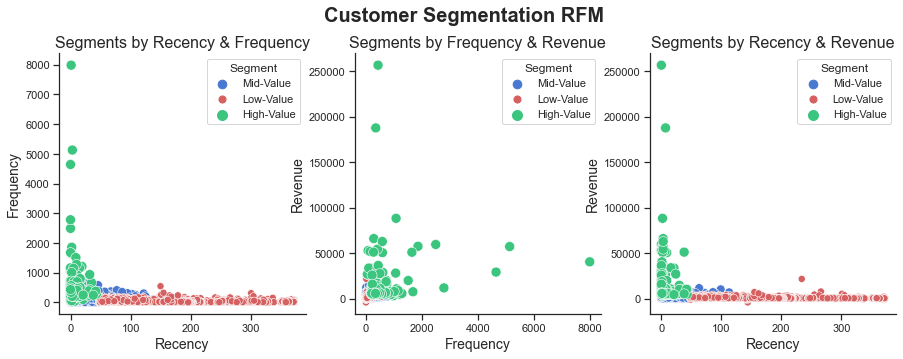

In [28]:
# Plotting the distribution of Clusters
sns.set(palette='muted', color_codes=True, style='white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.despine()
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,100), size_order=['High-Value','Mid-Value','Low-Value'],  palette=["b", "r", "#3bc57fff"])
sns.scatterplot(x='Frequency', y='Revenue', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,100), size_order=['High-Value','Mid-Value','Low-Value'], palette=["b", "r", "#3bc57fff"])
sns.scatterplot(x='Recency', y='Revenue', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,100), size_order=['High-Value','Mid-Value','Low-Value'], palette=["b", "r", "#3bc57fff"])
 
axs[0].set_title('Segments by Recency & Frequency', fontsize = 16)
axs[1].set_title('Segments by Frequency & Revenue', fontsize = 16)
axs[2].set_title('Segments by Recency & Revenue', fontsize = 16)

axs[0].set_xlabel('Recency', fontsize = 14)
axs[0].set_ylabel('Frequency', fontsize = 14)
axs[1].set_xlabel('Frequency', fontsize = 14)
axs[1].set_ylabel('Revenue', fontsize = 14)
axs[2].set_xlabel('Recency', fontsize = 14)
axs[2].set_ylabel('Revenue', fontsize = 14)

fig.suptitle('Customer Segmentation RFM', fontweight = 600, size=20)
plt.subplots_adjust(top=.85)

# Savinf fig
#fig2 = plt.gcf()
#plt.show()
#plt.draw()
#fig2.savefig('seg_cust.png')

ACTION POINTS:

High Value: Improve Retention

Mid Value: Improve Retention + Increase Frequency

Low Value: Increase Frequency

## 3. Customer Lifetime Value (LTV)

After segmenting the customers we can track customer lifetime value.

We invest in customers (acquisition costs, offline ads, promotions, discounts & etc.) to generate revenue and be profitable. 

These actions make some customers super valuable in terms of lifetime value but there are always some customers who pull down the profitability. 

Calculating Lifetime Value: select a time window (3, 6, 12, 24 months).

#### Historical CLV = the sum of revenues of all customer transactions multiplied by average or product-level profit margin.

*** There is no cost specified in the dataset. That’s why Revenue becomes the LTV directly.

If some customers are having very high negative lifetime value historically, it could be too late to take an action. At this point, we need to predict the future with ML.


In [29]:
# Create 3m and 6m dataframes
df_3m = df[(df.InvoiceDate < datetime(2011,6,1)) & (df.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)
df_6m = df[(df.InvoiceDate >= datetime(2011,6,1)) & (df.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)

# Create df_user for assigning segmentation scores
df_user_new = pd.DataFrame(df_3m['CustomerID'].unique())
df_user_new.columns = ['CustomerID']

In [30]:
######################### >>>> Calculate recency score <<<<

# Get the max purchase date for each customer 
df_max_purchase = df_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
df_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']

# The max purchase date is the observation point
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

# Merge with df_user_new
df_user_new = pd.merge(df_user_new, df_max_purchase[['CustomerID','Recency']], on='CustomerID')

# k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user_new[['Recency']])
df_user_new['RecencyCluster'] = kmeans.predict(df_user_new[['Recency']])
df_user_new = order_cluster('RecencyCluster', 'Recency',df_user_new,False)

######################### >>>> Calcuate frequency score <<<<
df_frequency = df_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']
df_user_new = pd.merge(df_user_new, df_frequency, on='CustomerID')

# k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user_new[['Frequency']])
df_user_new['FrequencyCluster'] = kmeans.predict(df_user_new[['Frequency']])
df_user_new = order_cluster('FrequencyCluster', 'Frequency',df_user_new,True)

######################### >>>> Calcuate revenue score <<<<
df_revenue = df_3m.groupby('CustomerID').Revenue.sum().reset_index()
df_user_new = pd.merge(df_user_new, df_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user_new[['Revenue']])
df_user_new['RevenueCluster'] = kmeans.predict(df_user_new[['Revenue']])
df_user_new = order_cluster('RevenueCluster', 'Revenue',df_user_new,True)


######################### >>>> Overall scoring
# Renaming columns
df_user_new.columns = ['CustomerID', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']
df_user_new['OverallScore'] = df_user_new['RecencyCluster'] + df_user_new['FrequencyCluster'] + df_user_new['RevenueCluster']
df_user_new['Segment'] = 'Low-Value'
df_user_new.loc[df_user_new['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user_new.loc[df_user_new['OverallScore']>4,'Segment'] = 'High-Value' 

df_user_new.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


### Calculate 6 months LTV for each customer which are going to be used for training our model.

Because we don't have the costs the LVT will be the Revenue itself.

In [31]:
# calculate revenue 6 months (LTV)
df_user_6m = df_6m.groupby('CustomerID').Revenue.sum().reset_index()
df_user_6m.columns = ['CustomerID','6m_Revenue']

Next step is to merge our 3 months and 6 months dataframes to see correlations between LTV and the feature set we have.

In [32]:
df_merge = pd.merge(df_user_new, df_user_6m, on='CustomerID', how='left')
df_merge = df_merge.fillna(0)
df_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment,6m_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


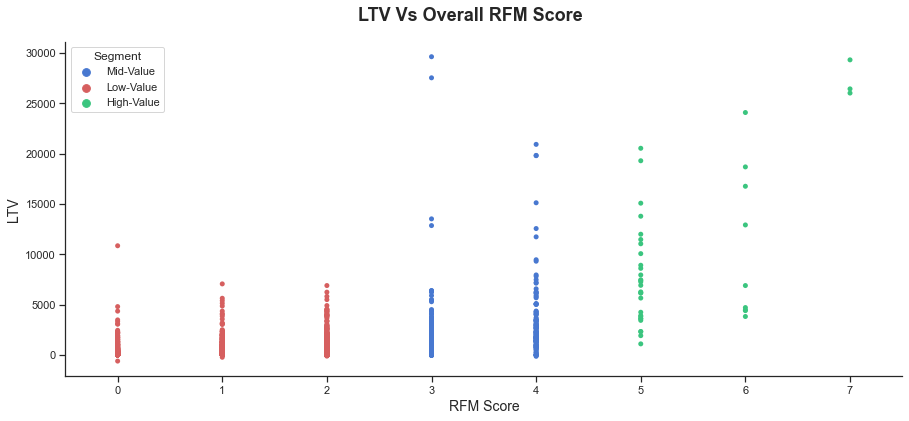

In [33]:
# Plotting the distribution of Clusters
cust_graph = df_merge[df_merge['6m_Revenue']<30000]

sns.set(palette='muted', color_codes=True, style='white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.figure(figsize=(15, 6))
sns.stripplot(x='OverallScore', y='6m_Revenue', hue='Segment', jitter=False, data=cust_graph, palette=["b", "r", "#3bc57fff"])
plt.ylabel('LTV', fontsize = 14)
plt.xlabel('RFM Score', fontsize = 14)
plt.suptitle('LTV Vs Overall RFM Score', fontweight = 600, size=18)
plt.subplots_adjust(wspace=0.3, hspace=3, top=.9)
sns.despine()

# Savinf fig
#fig3 = plt.gcf()
#plt.show()
#plt.draw()
#fig3.savefig('ltv_cust.png', dpi=500)

Positive correlation is quite visible here. High RFM score means high LTV.

### Apply clustering for 3 segments (number of segments depends on business goals): Low-LTV, Mid-LTV, High-LTV

In [34]:
# Remove outliers
df_merge = df_merge[df_merge['6m_Revenue']<df_merge['6m_Revenue'].quantile(0.99)]

# Creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_merge[['6m_Revenue']])
df_merge['LTVCluster'] = kmeans.predict(df_merge[['6m_Revenue']])

# Ordering cluster number based on LTV
df_merge = order_cluster('LTVCluster', '6m_Revenue',df_merge,True)

# Creating a new cluster df
df_cluster = df_merge.copy()

# Display details of the clusters
df_cluster.groupby('LTVCluster')['6m_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


2 is the best with average 323 LTV whereas 0 is the worst.

## Feature Engineering

#### Steps before training the machine learning model:

#### Feature engineering: convert categorical columns to numerical columns.
#### Check the correlation of features against the target/label, LTV clusters.
#### Split feature set and target/label (LTV) as X and y.
#### Create Training and Test dataset.

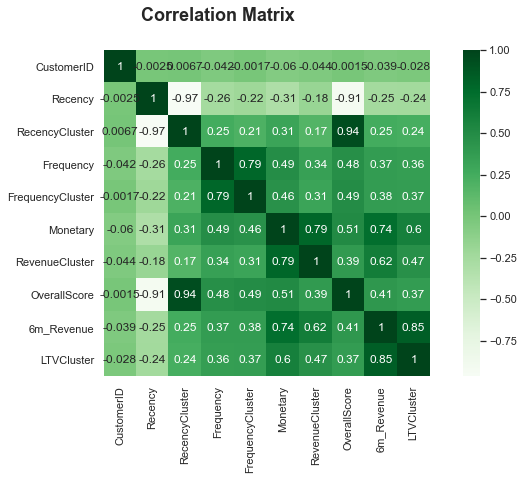

In [35]:
# Check for any multicollinearity between the numerical variables. 
sns.set(palette='muted', color_codes=True, style='whitegrid',font_scale=1)
plt.figure(figsize=(12, 6))
corr_matrix = df_cluster.corr()
sns.heatmap(corr_matrix, annot=True, square=True, cmap='Greens')
plt.suptitle('Correlation Matrix', fontweight = 600, fontsize = 18)
plt.show()


In [36]:
# Convert categorical columns to numerical
#convert categorical columns to numerical
df_cluster = pd.get_dummies(df_cluster)

In [37]:
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster          1.000000
6m_Revenue          0.845933
Monetary            0.600491
RevenueCluster      0.467191
OverallScore        0.373114
FrequencyCluster    0.366366
Frequency           0.359601
RecencyCluster      0.236899
CustomerID         -0.028401
Recency            -0.237249
Name: LTVCluster, dtype: float64

In [38]:
df_cluster['LTVCluster'].value_counts()

0    1394
1     371
2      56
Name: LTVCluster, dtype: int64

In [39]:
# Create X and y, X will be feature set and y is the label - LTV
X = df_cluster.drop(['LTVCluster','6m_Revenue'],axis=1)
y = df_cluster['LTVCluster']

data_dmatrix = xgb.DMatrix(data=X,label=y)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Class=0, n=1394 (76.551%)
Class=1, n=371 (20.373%)
Class=2, n=56 (3.075%)


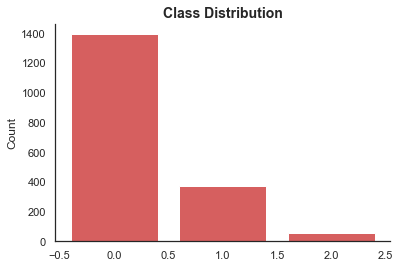

In [40]:
from collections import Counter
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
sns.set(palette='muted', color_codes=True, style='white')
plt.bar(counter.keys(), counter.values(), color='r')
plt.grid(b=None)
plt.ylabel('Count', fontsize = 12)
plt.title('Class Distribution', fontweight = 600, fontsize = 14)

plt.grid(b=None)
sns.despine()
# Savinf fig
#fig4 = plt.gcf()
#plt.show()
#plt.draw()
#fig4.savefig('class1.png', dpi=500)

### Generate synthetic samples SMOTE or Synthetic Minority Oversampling Technique

SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

It’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

Source: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Class=0, n=1394 (33.333%)
Class=1, n=1394 (33.333%)
Class=2, n=1394 (33.333%)


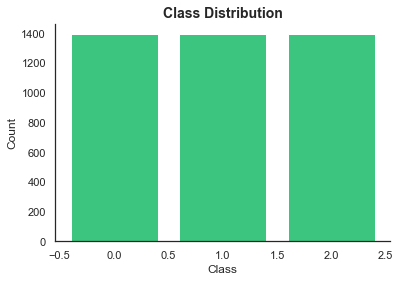

In [41]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# plot the distribution
sns.set(palette='muted', color_codes=True, style='white')
plt.bar(counter.keys(), counter.values(), color='#3bc57fff')
plt.grid(b=None)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Class', fontsize = 12)
plt.title('Class Distribution', fontweight = 600, fontsize = 14)
sns.despine()
plt.grid(b=None)
sns.despine()
# Savinf fig
#fig5 = plt.gcf()
#plt.show()
#plt.draw()
#fig5.savefig('class2.png', dpi=500)

In [42]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost Model

Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.86


              precision    recall  f1-score   support

           0       0.87      0.82      0.84       311
           1       0.79      0.81      0.80       261
           2       0.93      0.97      0.95       265

    accuracy                           0.86       837
   macro avg       0.86      0.87      0.86       837
weighted avg       0.86      0.86      0.86       837



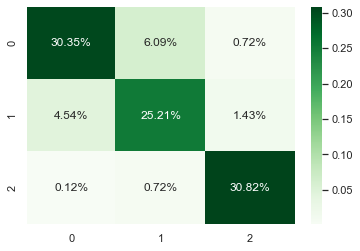

<Figure size 1296x432 with 0 Axes>

In [43]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective = 'multi:softprob', verbosity=0).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)


#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
heat= sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Greens')
plt.figure(figsize=(18, 6))


# Savinf fig

#figure = heat.get_figure()    
#figure.savefig('corr_before.png', dpi=500)

print('\n')
print(classification_report(y_test, y_pred))

In [44]:
# Compute the rmse by invoking the mean_sqaured_error function from sklearn's metrics module.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %f' % (rmse))

RMSE: 0.401610


In [45]:
# k-fold Cross Validation using XGBoost

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10, metrics= 'rmse', as_pandas=True, seed=123)

# cv_results contains train and test RMSE metrics for each boosting round.
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.532201,0.000909,0.533310,0.001145
1,0.514865,0.004173,0.516285,0.003007
2,0.499382,0.005162,0.501316,0.002297
3,0.487926,0.005612,0.490300,0.002796
4,0.475840,0.002640,0.479306,0.001408


In [46]:
# Extract and print the final boosting round metric.
print((cv_results["test-rmse-mean"]).tail(1))

49    0.396559
Name: test-rmse-mean, dtype: float64


## Visualize Feature Importance

#### Examine the importance of each feature column in the original dataset within the model

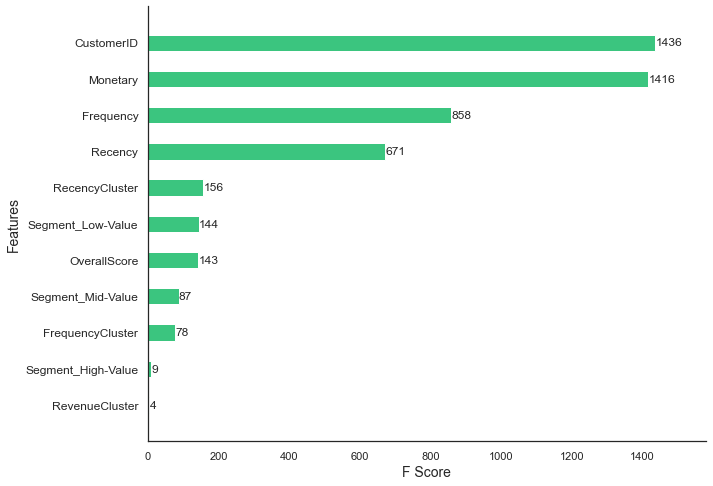

In [47]:
# Getting feature importance
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
sns.set(palette='muted', color_codes=True, style='white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plot_importance(ltv_xgb_model, ax=ax, color='#3bc57fff', height=0.45)
plt.title('', fontweight = 600, fontsize = 20)
plt.yticks(fontsize = 12)
plt.ylabel('Features', fontsize = 14)
plt.xlabel('F Score', fontsize = 14)
plt.grid(b=None)
sns.despine()

# Savinf fig
#fig8 = plt.gcf()
#plt.show()
#plt.draw()
#fig8.savefig('importance.png', dpi=500, bbox_inches = "tight")

## LogisticRegression Model

Accuracy of LogisticRegression on training set: 0.74
Accuracy of LogisticRegression on test set: 0.76


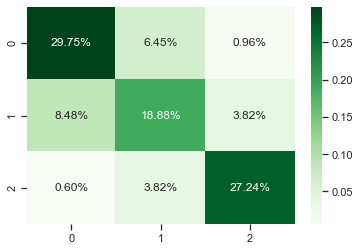

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       311
           1       0.65      0.61      0.63       261
           2       0.85      0.86      0.86       265

    accuracy                           0.76       837
   macro avg       0.75      0.76      0.75       837
weighted avg       0.76      0.76      0.76       837



In [48]:
from sklearn.linear_model import LogisticRegression 

logreg = LogisticRegression(random_state=0, multi_class='multinomial').fit(X_train, y_train)

# Predict the response for test dataset
logreg_pred = logreg.predict(X_test)
pd.DataFrame({'test':y_test, 'predicted':logreg_pred})

print('Accuracy of LogisticRegression on training set: {:.2f}'
       .format(logreg.score(X_train, y_train)))
print('Accuracy of LogisticRegression on test set: {:.2f}'
       .format(logreg.score(X_test, y_test)))

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, logreg_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Greens')
plt.show()

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, logreg_pred))